In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


from sklearn.datasets import make_blobs
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import matthews_corrcoef,cohen_kappa_score,balanced_accuracy_score


import lightgbm as lgb
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import uncertainty_sampling
from functools import partial
from modAL.batch import uncertainty_batch_sampling

import warnings

warnings.filterwarnings('ignore')

In [2]:
float_id1 = '4902337'
#float_id2 = '6901195'
float_id3 = '4903220'
data_source1="./dataset/PR_PF_"+float_id1+".csv"
#data_source2="./dataset/PR_PF_"+float_id2+".csv"
data_source3="./dataset/PR_PF_"+float_id3+".csv"
df1= pd.read_csv(data_source1)
#df2= pd.read_csv(data_source2)
df3= pd.read_csv(data_source3)
#data=pd.concat([df1,df2,df3])
#data

In [3]:
df1

,Date,Latitude,longitude,Pressure,Salinity,Temperature,QC,Label
0,-1.585326,-1.728482,0.521565,-0.884740,1.263216,0.821065,0,0
1,-1.585326,-1.728482,0.521565,-0.883036,1.263216,0.820925,0,0
2,-1.585326,-1.728482,0.521565,-0.881261,1.262159,0.820925,0,0
3,-1.585326,-1.728482,0.521565,-0.879487,1.262159,0.821065,0,0
4,-1.585326,-1.728482,0.521565,-0.877641,1.262159,0.821065,0,0
...,...,...,...,...,...,...,...,...
214895,1.974276,-1.605324,-0.343149,-0.800825,1.282237,1.124021,0,0
214896,1.974276,-1.605324,-0.343149,-0.800612,1.282237,1.123881,0,0
214897,1.974276,-1.605324,-0.343149,-0.800328,1.281180,1.123741,0,0
214898,1.974276,-1.605324,-0.343149,-0.800186,1.283294,1.123601,0,0


In [4]:
df3

,Date,Latitude,longitude,Pressure,Salinity,Temperature,QC,Label
0,-1.701129,-2.022791,-2.334865,-0.891179,1.033240,0.974810,0,0
1,-1.701129,-2.022791,-2.334865,-0.889613,1.023454,0.974443,0,0
2,-1.701129,-2.022791,-2.334865,-0.888047,1.022476,0.974565,0,0
3,-1.701129,-2.022791,-2.334865,-0.886418,1.043026,0.974076,0,0
4,-1.701129,-2.022791,-2.334865,-0.884852,1.044983,0.972609,0,0
...,...,...,...,...,...,...,...,...
281400,1.719970,0.835175,-0.340112,-0.738371,0.311051,0.462489,0,0
281401,1.719970,0.835175,-0.340112,-0.738183,0.311051,0.462734,0,0
281402,1.719970,0.835175,-0.340112,-0.738058,0.313008,0.462489,0,0
281403,1.719970,0.835175,-0.340112,-0.737870,0.313008,0.462245,0,0


In [5]:
df1[['Float']]="1"
df1

,Date,Latitude,longitude,Pressure,Salinity,Temperature,QC,Label,Float
0,-1.585326,-1.728482,0.521565,-0.884740,1.263216,0.821065,0,0,1
1,-1.585326,-1.728482,0.521565,-0.883036,1.263216,0.820925,0,0,1
2,-1.585326,-1.728482,0.521565,-0.881261,1.262159,0.820925,0,0,1
3,-1.585326,-1.728482,0.521565,-0.879487,1.262159,0.821065,0,0,1
4,-1.585326,-1.728482,0.521565,-0.877641,1.262159,0.821065,0,0,1
...,...,...,...,...,...,...,...,...,...
214895,1.974276,-1.605324,-0.343149,-0.800825,1.282237,1.124021,0,0,1
214896,1.974276,-1.605324,-0.343149,-0.800612,1.282237,1.123881,0,0,1
214897,1.974276,-1.605324,-0.343149,-0.800328,1.281180,1.123741,0,0,1
214898,1.974276,-1.605324,-0.343149,-0.800186,1.283294,1.123601,0,0,1


In [6]:
df3[['Float']]="3"
df3

,Date,Latitude,longitude,Pressure,Salinity,Temperature,QC,Label,Float
0,-1.701129,-2.022791,-2.334865,-0.891179,1.033240,0.974810,0,0,3
1,-1.701129,-2.022791,-2.334865,-0.889613,1.023454,0.974443,0,0,3
2,-1.701129,-2.022791,-2.334865,-0.888047,1.022476,0.974565,0,0,3
3,-1.701129,-2.022791,-2.334865,-0.886418,1.043026,0.974076,0,0,3
4,-1.701129,-2.022791,-2.334865,-0.884852,1.044983,0.972609,0,0,3
...,...,...,...,...,...,...,...,...,...
281400,1.719970,0.835175,-0.340112,-0.738371,0.311051,0.462489,0,0,3
281401,1.719970,0.835175,-0.340112,-0.738183,0.311051,0.462734,0,0,3
281402,1.719970,0.835175,-0.340112,-0.738058,0.313008,0.462489,0,0,3
281403,1.719970,0.835175,-0.340112,-0.737870,0.313008,0.462245,0,0,3


In [7]:
data=pd.concat([df1,df3])
data1=data[["Date","Latitude","longitude","Pressure","Salinity","Temperature","Float"]]
data2=data[["Date","Pressure","Salinity","Temperature","Float"]]

In [8]:
data1

,Date,Latitude,longitude,Pressure,Salinity,Temperature,Float
0,-1.585326,-1.728482,0.521565,-0.884740,1.263216,0.821065,1
1,-1.585326,-1.728482,0.521565,-0.883036,1.263216,0.820925,1
2,-1.585326,-1.728482,0.521565,-0.881261,1.262159,0.820925,1
3,-1.585326,-1.728482,0.521565,-0.879487,1.262159,0.821065,1
4,-1.585326,-1.728482,0.521565,-0.877641,1.262159,0.821065,1
...,...,...,...,...,...,...,...
281400,1.719970,0.835175,-0.340112,-0.738371,0.311051,0.462489,3
281401,1.719970,0.835175,-0.340112,-0.738183,0.311051,0.462734,3
281402,1.719970,0.835175,-0.340112,-0.738058,0.313008,0.462489,3
281403,1.719970,0.835175,-0.340112,-0.737870,0.313008,0.462245,3


In [9]:
data2

,Date,Pressure,Salinity,Temperature,Float
0,-1.585326,-0.884740,1.263216,0.821065,1
1,-1.585326,-0.883036,1.263216,0.820925,1
2,-1.585326,-0.881261,1.262159,0.820925,1
3,-1.585326,-0.879487,1.262159,0.821065,1
4,-1.585326,-0.877641,1.262159,0.821065,1
...,...,...,...,...,...
281400,1.719970,-0.738371,0.311051,0.462489,3
281401,1.719970,-0.738183,0.311051,0.462734,3
281402,1.719970,-0.738058,0.313008,0.462489,3
281403,1.719970,-0.737870,0.313008,0.462245,3


In [10]:
#split the data and make sure the proportion in train and test set are equal
def getRandomSplit(data, size):
    from sklearn.model_selection import StratifiedShuffleSplit
    split = StratifiedShuffleSplit(n_splits = 1,test_size = size,random_state = 42)

    for train_index,test_index in split.split(data,data.iloc[:,-1]):
        train_set = data.iloc[train_index,:]
        test_set = data.iloc[test_index,:]

    print(len(train_set),len(test_set))
    return train_set,test_set

In [11]:
train_set1,test_set1 = getRandomSplit(data1,0.9)# random 10 90

49630 446675


In [12]:
x,y=train_set1.shape ##no qc
#pool 
X_train = train_set1.iloc[:,0:y-1]
y_train = train_set1.iloc[:,y-1]
X_test=test_set1.iloc[:,0:y-1]
y_tru=test_set1.iloc[:,y-1]

In [13]:
def computeMetric(y_tru,y_pre):
    acc = accuracy_score(y_tru,y_pre)
    pre=precision_score(y_tru,y_pre,average='macro')
    recall=recall_score(y_tru,y_pre,average='macro')
    cm=confusion_matrix(y_tru,y_pre)
    f1 = f1_score(y_tru,y_pre,average='macro')
    mcc=matthews_corrcoef(y_tru, y_pre)
    kappa=cohen_kappa_score(y_tru, y_pre)
    bac=balanced_accuracy_score(y_tru,y_pre)
    print("acc:",acc)
    print("precision:",pre)
    print("recall:",recall)
    print("cm:",cm)
    print("f1:",f1)
    print("balanced acc:",bac)
    print("MCC:", mcc)
    print("Kappa:",kappa)
    
    #confusion matrix
    cmap1 = sns.diverging_palette(260,-10,s=50, l=75, n=5, as_cmap=True)
    plt.subplots(figsize=(12,8))
    cf_matrix = confusion_matrix(y_tru, y_pre)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})
    
    return f1

Learning rate set to 0.054578
0:	learn: 0.5952715	total: 83.4ms	remaining: 1m 23s
1:	learn: 0.5208181	total: 90.2ms	remaining: 45s
2:	learn: 0.4672421	total: 97.4ms	remaining: 32.4s
3:	learn: 0.4274277	total: 104ms	remaining: 25.8s
4:	learn: 0.3776711	total: 110ms	remaining: 22s
5:	learn: 0.3414328	total: 117ms	remaining: 19.4s
6:	learn: 0.3024650	total: 123ms	remaining: 17.5s
7:	learn: 0.2777442	total: 130ms	remaining: 16.1s
8:	learn: 0.2589165	total: 136ms	remaining: 15s
9:	learn: 0.2467737	total: 142ms	remaining: 14.1s
10:	learn: 0.2368445	total: 149ms	remaining: 13.4s
11:	learn: 0.2144235	total: 155ms	remaining: 12.8s
12:	learn: 0.2015697	total: 162ms	remaining: 12.3s
13:	learn: 0.1920388	total: 169ms	remaining: 11.9s
14:	learn: 0.1761772	total: 175ms	remaining: 11.5s
15:	learn: 0.1647168	total: 182ms	remaining: 11.2s
16:	learn: 0.1524391	total: 188ms	remaining: 10.9s
17:	learn: 0.1439415	total: 195ms	remaining: 10.6s
18:	learn: 0.1386013	total: 203ms	remaining: 10.5s
19:	learn: 0.

186:	learn: 0.0019906	total: 1.38s	remaining: 5.99s
187:	learn: 0.0019698	total: 1.39s	remaining: 5.99s
188:	learn: 0.0019544	total: 1.39s	remaining: 5.98s
189:	learn: 0.0019252	total: 1.4s	remaining: 5.97s
190:	learn: 0.0019012	total: 1.41s	remaining: 5.96s
191:	learn: 0.0018901	total: 1.41s	remaining: 5.95s
192:	learn: 0.0018630	total: 1.42s	remaining: 5.94s
193:	learn: 0.0018405	total: 1.43s	remaining: 5.93s
194:	learn: 0.0018244	total: 1.43s	remaining: 5.92s
195:	learn: 0.0018006	total: 1.44s	remaining: 5.91s
196:	learn: 0.0017764	total: 1.45s	remaining: 5.9s
197:	learn: 0.0017663	total: 1.45s	remaining: 5.89s
198:	learn: 0.0017349	total: 1.46s	remaining: 5.88s
199:	learn: 0.0017154	total: 1.47s	remaining: 5.86s
200:	learn: 0.0016926	total: 1.47s	remaining: 5.85s
201:	learn: 0.0016772	total: 1.48s	remaining: 5.84s
202:	learn: 0.0016621	total: 1.49s	remaining: 5.83s
203:	learn: 0.0016215	total: 1.49s	remaining: 5.82s
204:	learn: 0.0016215	total: 1.5s	remaining: 5.81s
205:	learn: 0.0

357:	learn: 0.0012111	total: 2.37s	remaining: 4.25s
358:	learn: 0.0012111	total: 2.37s	remaining: 4.24s
359:	learn: 0.0012111	total: 2.38s	remaining: 4.23s
360:	learn: 0.0012111	total: 2.38s	remaining: 4.22s
361:	learn: 0.0012111	total: 2.39s	remaining: 4.21s
362:	learn: 0.0012111	total: 2.39s	remaining: 4.2s
363:	learn: 0.0012111	total: 2.4s	remaining: 4.19s
364:	learn: 0.0012111	total: 2.4s	remaining: 4.18s
365:	learn: 0.0012111	total: 2.41s	remaining: 4.18s
366:	learn: 0.0012111	total: 2.42s	remaining: 4.17s
367:	learn: 0.0012111	total: 2.42s	remaining: 4.16s
368:	learn: 0.0012111	total: 2.43s	remaining: 4.15s
369:	learn: 0.0012111	total: 2.43s	remaining: 4.14s
370:	learn: 0.0012111	total: 2.44s	remaining: 4.13s
371:	learn: 0.0012111	total: 2.44s	remaining: 4.12s
372:	learn: 0.0012111	total: 2.44s	remaining: 4.11s
373:	learn: 0.0012111	total: 2.45s	remaining: 4.1s
374:	learn: 0.0012111	total: 2.46s	remaining: 4.09s
375:	learn: 0.0012111	total: 2.46s	remaining: 4.08s
376:	learn: 0.00

542:	learn: 0.0012110	total: 3.36s	remaining: 2.83s
543:	learn: 0.0012110	total: 3.36s	remaining: 2.82s
544:	learn: 0.0012110	total: 3.37s	remaining: 2.81s
545:	learn: 0.0012110	total: 3.37s	remaining: 2.81s
546:	learn: 0.0012110	total: 3.38s	remaining: 2.8s
547:	learn: 0.0012110	total: 3.38s	remaining: 2.79s
548:	learn: 0.0012110	total: 3.39s	remaining: 2.78s
549:	learn: 0.0012110	total: 3.39s	remaining: 2.78s
550:	learn: 0.0012110	total: 3.4s	remaining: 2.77s
551:	learn: 0.0012110	total: 3.4s	remaining: 2.76s
552:	learn: 0.0012110	total: 3.41s	remaining: 2.76s
553:	learn: 0.0012110	total: 3.41s	remaining: 2.75s
554:	learn: 0.0012110	total: 3.42s	remaining: 2.74s
555:	learn: 0.0012110	total: 3.42s	remaining: 2.73s
556:	learn: 0.0012110	total: 3.43s	remaining: 2.73s
557:	learn: 0.0012110	total: 3.43s	remaining: 2.72s
558:	learn: 0.0012110	total: 3.44s	remaining: 2.71s
559:	learn: 0.0012110	total: 3.44s	remaining: 2.71s
560:	learn: 0.0012110	total: 3.45s	remaining: 2.7s
561:	learn: 0.00

727:	learn: 0.0012110	total: 4.35s	remaining: 1.63s
728:	learn: 0.0012110	total: 4.36s	remaining: 1.62s
729:	learn: 0.0012110	total: 4.37s	remaining: 1.61s
730:	learn: 0.0012110	total: 4.37s	remaining: 1.61s
731:	learn: 0.0012110	total: 4.38s	remaining: 1.6s
732:	learn: 0.0012110	total: 4.38s	remaining: 1.6s
733:	learn: 0.0012110	total: 4.39s	remaining: 1.59s
734:	learn: 0.0012110	total: 4.39s	remaining: 1.58s
735:	learn: 0.0012110	total: 4.4s	remaining: 1.58s
736:	learn: 0.0012110	total: 4.4s	remaining: 1.57s
737:	learn: 0.0012110	total: 4.41s	remaining: 1.56s
738:	learn: 0.0012110	total: 4.41s	remaining: 1.56s
739:	learn: 0.0012110	total: 4.42s	remaining: 1.55s
740:	learn: 0.0012110	total: 4.42s	remaining: 1.55s
741:	learn: 0.0012110	total: 4.43s	remaining: 1.54s
742:	learn: 0.0012110	total: 4.43s	remaining: 1.53s
743:	learn: 0.0012110	total: 4.44s	remaining: 1.53s
744:	learn: 0.0012110	total: 4.45s	remaining: 1.52s
745:	learn: 0.0012110	total: 4.45s	remaining: 1.51s
746:	learn: 0.00

913:	learn: 0.0011823	total: 5.34s	remaining: 503ms
914:	learn: 0.0011823	total: 5.35s	remaining: 497ms
915:	learn: 0.0011823	total: 5.35s	remaining: 491ms
916:	learn: 0.0011823	total: 5.36s	remaining: 485ms
917:	learn: 0.0011823	total: 5.36s	remaining: 479ms
918:	learn: 0.0011823	total: 5.37s	remaining: 473ms
919:	learn: 0.0011823	total: 5.37s	remaining: 467ms
920:	learn: 0.0011822	total: 5.38s	remaining: 461ms
921:	learn: 0.0011822	total: 5.38s	remaining: 455ms
922:	learn: 0.0011822	total: 5.39s	remaining: 449ms
923:	learn: 0.0011822	total: 5.39s	remaining: 444ms
924:	learn: 0.0011822	total: 5.4s	remaining: 438ms
925:	learn: 0.0011822	total: 5.4s	remaining: 432ms
926:	learn: 0.0011822	total: 5.41s	remaining: 426ms
927:	learn: 0.0011822	total: 5.41s	remaining: 420ms
928:	learn: 0.0011822	total: 5.42s	remaining: 414ms
929:	learn: 0.0011822	total: 5.42s	remaining: 408ms
930:	learn: 0.0011822	total: 5.43s	remaining: 402ms
931:	learn: 0.0011822	total: 5.43s	remaining: 396ms
932:	learn: 0.

0.9999794825940678

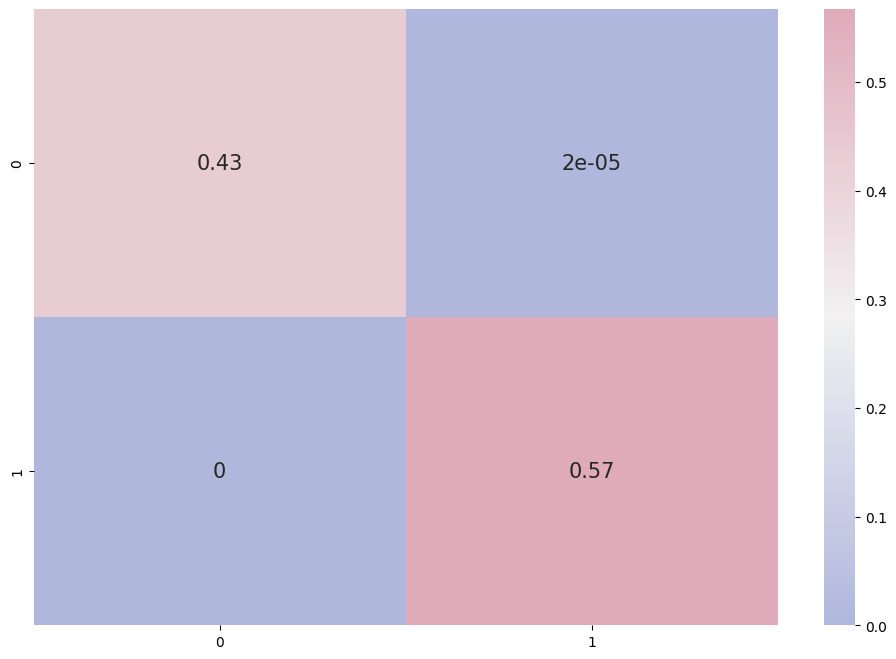

In [14]:
clf = CatBoostClassifier(loss_function='Logloss')

clf.fit(X_train, y_train)
y_pre=clf.predict(X_test)
computeMetric(y_tru,y_pre)

In [15]:
train_set2,test_set2 = getRandomSplit(data1,0.7)# random 30 70

148891 347414


In [16]:
x,y=train_set2.shape ##no qc
#pool 
X_train2 = train_set2.iloc[:,0:y-1]
y_train2 = train_set2.iloc[:,y-1]
X_test2=test_set2.iloc[:,0:y-1]
y_tru2=test_set2.iloc[:,y-1]

Learning rate set to 0.087247
0:	learn: 0.5500061	total: 25.5ms	remaining: 25.5s
1:	learn: 0.4409211	total: 37.2ms	remaining: 18.6s
2:	learn: 0.3605000	total: 49.4ms	remaining: 16.4s
3:	learn: 0.2968181	total: 62.7ms	remaining: 15.6s
4:	learn: 0.2570443	total: 74.8ms	remaining: 14.9s
5:	learn: 0.2268167	total: 87.4ms	remaining: 14.5s
6:	learn: 0.2005676	total: 102ms	remaining: 14.5s
7:	learn: 0.1718249	total: 116ms	remaining: 14.4s
8:	learn: 0.1552368	total: 130ms	remaining: 14.3s
9:	learn: 0.1437427	total: 142ms	remaining: 14.1s
10:	learn: 0.1335486	total: 154ms	remaining: 13.9s
11:	learn: 0.1243009	total: 166ms	remaining: 13.7s
12:	learn: 0.1121411	total: 177ms	remaining: 13.5s
13:	learn: 0.1035319	total: 189ms	remaining: 13.3s
14:	learn: 0.0901192	total: 202ms	remaining: 13.3s
15:	learn: 0.0804667	total: 216ms	remaining: 13.3s
16:	learn: 0.0754131	total: 228ms	remaining: 13.2s
17:	learn: 0.0684588	total: 239ms	remaining: 13.1s
18:	learn: 0.0644219	total: 251ms	remaining: 13s
19:	lea

163:	learn: 0.0006334	total: 2.03s	remaining: 10.3s
164:	learn: 0.0006334	total: 2.04s	remaining: 10.3s
165:	learn: 0.0006334	total: 2.05s	remaining: 10.3s
166:	learn: 0.0006334	total: 2.06s	remaining: 10.3s
167:	learn: 0.0006334	total: 2.07s	remaining: 10.2s
168:	learn: 0.0006334	total: 2.08s	remaining: 10.2s
169:	learn: 0.0006334	total: 2.09s	remaining: 10.2s
170:	learn: 0.0006334	total: 2.1s	remaining: 10.2s
171:	learn: 0.0006334	total: 2.11s	remaining: 10.2s
172:	learn: 0.0006334	total: 2.12s	remaining: 10.1s
173:	learn: 0.0006334	total: 2.13s	remaining: 10.1s
174:	learn: 0.0006334	total: 2.14s	remaining: 10.1s
175:	learn: 0.0006334	total: 2.15s	remaining: 10.1s
176:	learn: 0.0006334	total: 2.16s	remaining: 10s
177:	learn: 0.0006334	total: 2.17s	remaining: 10s
178:	learn: 0.0006334	total: 2.18s	remaining: 10s
179:	learn: 0.0006334	total: 2.19s	remaining: 9.99s
180:	learn: 0.0006334	total: 2.2s	remaining: 9.97s
181:	learn: 0.0006334	total: 2.21s	remaining: 9.95s
182:	learn: 0.000633

329:	learn: 0.0006334	total: 3.76s	remaining: 7.63s
330:	learn: 0.0006334	total: 3.77s	remaining: 7.62s
331:	learn: 0.0006334	total: 3.78s	remaining: 7.61s
332:	learn: 0.0006334	total: 3.79s	remaining: 7.6s
333:	learn: 0.0006334	total: 3.8s	remaining: 7.58s
334:	learn: 0.0006334	total: 3.81s	remaining: 7.57s
335:	learn: 0.0006334	total: 3.82s	remaining: 7.55s
336:	learn: 0.0006334	total: 3.83s	remaining: 7.54s
337:	learn: 0.0006334	total: 3.85s	remaining: 7.53s
338:	learn: 0.0006334	total: 3.85s	remaining: 7.52s
339:	learn: 0.0006334	total: 3.87s	remaining: 7.5s
340:	learn: 0.0006334	total: 3.88s	remaining: 7.49s
341:	learn: 0.0006334	total: 3.88s	remaining: 7.47s
342:	learn: 0.0006334	total: 3.89s	remaining: 7.46s
343:	learn: 0.0006334	total: 3.9s	remaining: 7.45s
344:	learn: 0.0006334	total: 3.91s	remaining: 7.43s
345:	learn: 0.0006334	total: 3.92s	remaining: 7.42s
346:	learn: 0.0006334	total: 3.93s	remaining: 7.4s
347:	learn: 0.0006334	total: 3.94s	remaining: 7.39s
348:	learn: 0.000

493:	learn: 0.0006334	total: 5.45s	remaining: 5.58s
494:	learn: 0.0006334	total: 5.46s	remaining: 5.57s
495:	learn: 0.0006334	total: 5.47s	remaining: 5.56s
496:	learn: 0.0006334	total: 5.48s	remaining: 5.54s
497:	learn: 0.0006334	total: 5.49s	remaining: 5.53s
498:	learn: 0.0006334	total: 5.5s	remaining: 5.52s
499:	learn: 0.0006334	total: 5.51s	remaining: 5.51s
500:	learn: 0.0006334	total: 5.52s	remaining: 5.49s
501:	learn: 0.0006334	total: 5.53s	remaining: 5.48s
502:	learn: 0.0006334	total: 5.54s	remaining: 5.47s
503:	learn: 0.0006334	total: 5.54s	remaining: 5.46s
504:	learn: 0.0006334	total: 5.55s	remaining: 5.45s
505:	learn: 0.0006334	total: 5.56s	remaining: 5.43s
506:	learn: 0.0006334	total: 5.57s	remaining: 5.42s
507:	learn: 0.0006334	total: 5.58s	remaining: 5.41s
508:	learn: 0.0006334	total: 5.59s	remaining: 5.4s
509:	learn: 0.0006334	total: 5.6s	remaining: 5.38s
510:	learn: 0.0006334	total: 5.61s	remaining: 5.37s
511:	learn: 0.0006334	total: 5.62s	remaining: 5.36s
512:	learn: 0.0

654:	learn: 0.0006334	total: 7.09s	remaining: 3.73s
655:	learn: 0.0006334	total: 7.1s	remaining: 3.72s
656:	learn: 0.0006334	total: 7.11s	remaining: 3.71s
657:	learn: 0.0006334	total: 7.12s	remaining: 3.7s
658:	learn: 0.0006334	total: 7.13s	remaining: 3.69s
659:	learn: 0.0006334	total: 7.14s	remaining: 3.68s
660:	learn: 0.0006334	total: 7.15s	remaining: 3.67s
661:	learn: 0.0006334	total: 7.16s	remaining: 3.66s
662:	learn: 0.0006334	total: 7.17s	remaining: 3.65s
663:	learn: 0.0006334	total: 7.18s	remaining: 3.63s
664:	learn: 0.0006334	total: 7.19s	remaining: 3.62s
665:	learn: 0.0006334	total: 7.21s	remaining: 3.61s
666:	learn: 0.0006334	total: 7.22s	remaining: 3.6s
667:	learn: 0.0006334	total: 7.23s	remaining: 3.59s
668:	learn: 0.0006334	total: 7.24s	remaining: 3.58s
669:	learn: 0.0006334	total: 7.25s	remaining: 3.57s
670:	learn: 0.0006334	total: 7.26s	remaining: 3.56s
671:	learn: 0.0006334	total: 7.27s	remaining: 3.55s
672:	learn: 0.0006334	total: 7.28s	remaining: 3.54s
673:	learn: 0.0

822:	learn: 0.0006334	total: 8.85s	remaining: 1.9s
823:	learn: 0.0006334	total: 8.86s	remaining: 1.89s
824:	learn: 0.0006334	total: 8.87s	remaining: 1.88s
825:	learn: 0.0006334	total: 8.88s	remaining: 1.87s
826:	learn: 0.0006334	total: 8.89s	remaining: 1.86s
827:	learn: 0.0006334	total: 8.9s	remaining: 1.85s
828:	learn: 0.0006334	total: 8.91s	remaining: 1.84s
829:	learn: 0.0006334	total: 8.92s	remaining: 1.83s
830:	learn: 0.0006334	total: 8.93s	remaining: 1.82s
831:	learn: 0.0006334	total: 8.94s	remaining: 1.8s
832:	learn: 0.0006334	total: 8.95s	remaining: 1.79s
833:	learn: 0.0006334	total: 8.96s	remaining: 1.78s
834:	learn: 0.0006334	total: 8.97s	remaining: 1.77s
835:	learn: 0.0006334	total: 8.98s	remaining: 1.76s
836:	learn: 0.0006334	total: 8.99s	remaining: 1.75s
837:	learn: 0.0006334	total: 9s	remaining: 1.74s
838:	learn: 0.0006334	total: 9.01s	remaining: 1.73s
839:	learn: 0.0006334	total: 9.02s	remaining: 1.72s
840:	learn: 0.0006334	total: 9.03s	remaining: 1.71s
841:	learn: 0.0006

982:	learn: 0.0006334	total: 10.5s	remaining: 182ms
983:	learn: 0.0006334	total: 10.6s	remaining: 172ms
984:	learn: 0.0006334	total: 10.6s	remaining: 161ms
985:	learn: 0.0006334	total: 10.6s	remaining: 150ms
986:	learn: 0.0006334	total: 10.6s	remaining: 139ms
987:	learn: 0.0006334	total: 10.6s	remaining: 129ms
988:	learn: 0.0006334	total: 10.6s	remaining: 118ms
989:	learn: 0.0006334	total: 10.6s	remaining: 107ms
990:	learn: 0.0006334	total: 10.6s	remaining: 96.6ms
991:	learn: 0.0006334	total: 10.6s	remaining: 85.8ms
992:	learn: 0.0006334	total: 10.7s	remaining: 75.1ms
993:	learn: 0.0006334	total: 10.7s	remaining: 64.4ms
994:	learn: 0.0006334	total: 10.7s	remaining: 53.6ms
995:	learn: 0.0006334	total: 10.7s	remaining: 42.9ms
996:	learn: 0.0006334	total: 10.7s	remaining: 32.2ms
997:	learn: 0.0006334	total: 10.7s	remaining: 21.5ms
998:	learn: 0.0006334	total: 10.7s	remaining: 10.7ms
999:	learn: 0.0006334	total: 10.7s	remaining: 0us
acc: 0.9999942431796071
precision: 0.9999949234971013
rec

0.9999941379084776

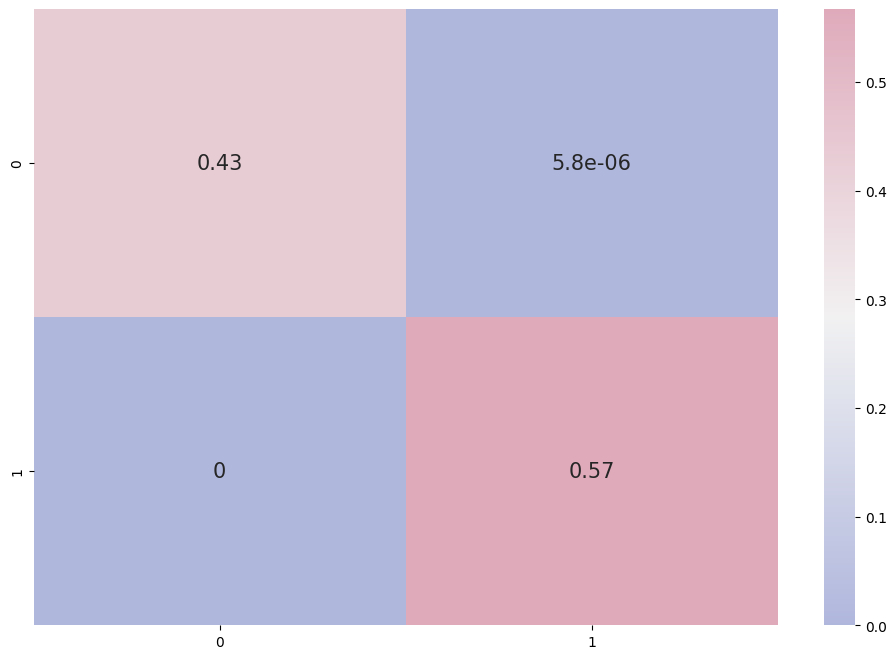

In [17]:
clf = CatBoostClassifier(loss_function='Logloss')
clf.fit(X_train2, y_train2)
y_pre2=clf.predict(X_test2)
computeMetric(y_tru2,y_pre2)